In [ ]:

# IMPORTANT: RUN THIS CELL IN ORDER TO IMPORT YOUR KAGGLE DATA SOURCES
# TO THE CORRECT LOCATION (/kaggle/input) IN YOUR NOTEBOOK,
# THEN FEEL FREE TO DELETE THIS CELL.
# NOTE: THIS NOTEBOOK ENVIRONMENT DIFFERS FROM KAGGLE'S PYTHON
# ENVIRONMENT SO THERE MAY BE MISSING LIBRARIES USED BY YOUR
# NOTEBOOK.

import os
import sys
from tempfile import NamedTemporaryFile
from urllib.request import urlopen
from urllib.parse import unquote, urlparse
from urllib.error import HTTPError
from zipfile import ZipFile
import tarfile
import shutil

CHUNK_SIZE = 40960
DATA_SOURCE_MAPPING = 'predict-the-rotor-bearing-temperature:https%3A%2F%2Fstorage.googleapis.com%2Fkaggle-data-sets%2F4229028%2F7291652%2Fbundle%2Farchive.zip%3FX-Goog-Algorithm%3DGOOG4-RSA-SHA256%26X-Goog-Credential%3Dgcp-kaggle-com%2540kaggle-161607.iam.gserviceaccount.com%252F20240413%252Fauto%252Fstorage%252Fgoog4_request%26X-Goog-Date%3D20240413T155817Z%26X-Goog-Expires%3D259200%26X-Goog-SignedHeaders%3Dhost%26X-Goog-Signature%3D4efe597db4a7c00379b0243a4a2af6ea64c592c119245cdbf9b51e6580237e1a8dd39d75051f2c7e0724cb045555b9508ae7a1afc9821295e784dba3a9c1b75d5bd028dc0c72468dfa7847d29d413809f5be27073f5d5f7c9475b507101042e204a2b0253f657dc246f4e5e52d4c8686ac3a08db2d499a94dfe068d965f29dc7c52fe54d75933b64e5621f5f68108ee4d1de4cba78aeeb2af54b6657a28fca5129f4d108f3e7b9c9f06a9cfc13951b38aea3efb81bbb8dfc811ed20d7995c08ee7017f3eb7cf7bd08e6921eceabdb4a25492cb103804a9fe8c84b8514091c61a1377bf439b6d0488f389f70915e3d6c2771e6b499380c1f3b9ab755e04bfcfba'

KAGGLE_INPUT_PATH='content/kaggle/input'
KAGGLE_WORKING_PATH='content/kaggle/working'
KAGGLE_SYMLINK='kaggle'

!umount content/kaggle/input/ 2> /dev/null
shutil.rmtree('content/kaggle/input', ignore_errors=True)
os.makedirs(KAGGLE_INPUT_PATH, 0o777, exist_ok=True)
os.makedirs(KAGGLE_WORKING_PATH, 0o777, exist_ok=True)

try:
  os.symlink(KAGGLE_INPUT_PATH, os.path.join("..", 'input'), target_is_directory=True)
except FileExistsError:
  pass
try:
  os.symlink(KAGGLE_WORKING_PATH, os.path.join("..", 'working'), target_is_directory=True)
except FileExistsError:
  pass

for data_source_mapping in DATA_SOURCE_MAPPING.split(','):
    directory, download_url_encoded = data_source_mapping.split(':')
    download_url = unquote(download_url_encoded)
    filename = urlparse(download_url).path
    destination_path = os.path.join(KAGGLE_INPUT_PATH, directory)
    try:
        with urlopen(download_url) as fileres, NamedTemporaryFile() as tfile:
            total_length = fileres.headers['content-length']
            print(f'Downloading {directory}, {total_length} bytes compressed')
            dl = 0
            data = fileres.read(CHUNK_SIZE)
            while len(data) > 0:
                dl += len(data)
                tfile.write(data)
                done = int(50 * dl / int(total_length))
                sys.stdout.write(f"\r[{'=' * done}{' ' * (50-done)}] {dl} bytes downloaded")
                sys.stdout.flush()
                data = fileres.read(CHUNK_SIZE)
            if filename.endswith('.zip'):
              with ZipFile(tfile) as zfile:
                zfile.extractall(destination_path)
            else:
              with tarfile.open(tfile.name) as tarfile:
                tarfile.extractall(destination_path)
            print(f'\nDownloaded and uncompressed: {directory}')
    except HTTPError as e:
        print(f'Failed to load (likely expired) {download_url} to path {destination_path}')
        continue
    except OSError as e:
        print(f'Failed to load {download_url} to path {destination_path}')
        continue

print('Data source import complete.')


[==================================================] 80245545 bytes downloaded
Downloaded and uncompressed: predict-the-rotor-bearing-temperature
Data source import complete.


In [ ]:
import numpy as np
import pandas as pd

## Get the Data

In [ ]:
# Data with labels
df = pd.read_csv("content/kaggle/input/predict-the-rotor-bearing-temperature/IEEE_train_data.csv")

# Data without labels
df_unknown = pd.read_csv("content/kaggle/input/predict-the-rotor-bearing-temperature/IEEE_test_data.csv")

## Check Data Structure

In [ ]:
df.head()

,id,timestamp,active_power_calculated_by_converter,active_power_raw,ambient_temperature,generator_speed,generator_winding_temp_max,grid_power10min_average,nc1_inside_temp,nacelle_temp,reactice_power_calculated_by_converter,reactive_power,wind_direction_raw,wind_speed_raw,wind_speed_turbulence,turbine_id,Target
0,0,6/22/2021 13:15,59.071225,59.117203,35.765579,NaN,64.812227,167.234988,31.835583,35.661191,18.228060,24.117071,316.953893,4.016191,0.524196,Turbine_01,48.670906
1,1,11/6/2021 17:40,258.278976,253.123637,33.392501,789.391492,57.227210,223.845406,32.870656,32.916340,84.444679,102.651681,70.390775,5.198709,0.311840,Turbine_97,47.779032
2,2,12/23/2021 21:08,234.884260,236.785260,33.320189,NaN,47.570285,182.448718,33.043858,29.726347,19.863061,38.311028,302.287781,5.443600,0.367809,Turbine_158,45.542946
3,3,1/2/2021 16:01,50.535151,37.784692,NaN,NaN,33.838225,14.912772,33.752039,30.534683,94.085461,96.431728,93.148946,3.971027,0.631113,Turbine_20,47.515691
4,4,12/6/2021 17:46,247.842835,241.342895,32.897556,NaN,64.972858,226.304581,32.558620,32.711412,93.393299,103.011902,140.825768,4.746520,0.341984,Turbine_20,44.625755


In [ ]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 591239 entries, 0 to 591238
Data columns (total 17 columns):
 #   Column                                  Non-Null Count   Dtype  
---  ------                                  --------------   -----  
 0   id                                      591239 non-null  int64  
 1   timestamp                               591239 non-null  object 
 2   active_power_calculated_by_converter    591229 non-null  float64
 3   active_power_raw                        591222 non-null  float64
 4   ambient_temperature                     581442 non-null  float64
 5   generator_speed                         274403 non-null  float64
 6   generator_winding_temp_max              591238 non-null  float64
 7   grid_power10min_average                 591204 non-null  float64
 8   nc1_inside_temp                         591007 non-null  float64
 9   nacelle_temp                            591021 non-null  float64
 10  reactice_power_calculated_by_converter  5912

In [ ]:
df.describe()

,id,active_power_calculated_by_converter,active_power_raw,ambient_temperature,generator_speed,generator_winding_temp_max,grid_power10min_average,nc1_inside_temp,nacelle_temp,reactice_power_calculated_by_converter,reactive_power,wind_direction_raw,wind_speed_raw,wind_speed_turbulence,Target
count,591239.00000,591229.000000,591222.000000,581442.000000,2.744030e+05,591238.000000,591204.000000,591007.000000,591021.000000,591235.000000,591237.000000,591232.000000,591238.000000,591224.000000,591239.000000
mean,295619.00000,525.866717,537.619368,25.575695,9.335539e+02,60.726657,527.539115,31.755925,31.688878,111.082286,133.693467,199.593409,5.894841,0.652084,46.329114
std,170676.14224,474.855567,482.605257,8.029416,1.931939e+02,9.722767,472.733821,3.924531,3.551064,78.311331,91.330276,104.625105,1.979821,0.317721,2.618603
min,0.00000,0.000026,0.000008,5.616541,2.380000e-08,25.636366,0.000419,11.213145,16.010218,-318.393722,-5.305059,0.309692,0.904500,0.000155,26.284803
25%,147809.50000,149.209960,155.521434,17.086869,8.179038e+02,54.910274,146.952599,29.915109,30.270897,81.511974,96.038854,99.017112,4.398367,0.432198,44.817109
50%,295619.00000,380.214829,384.222188,27.923465,9.392465e+02,60.033130,391.300458,31.763931,31.963117,92.008869,107.639515,232.991131,5.635837,0.584165,46.301372
75%,443428.50000,781.068481,799.942037,32.175093,1.075727e+03,65.733199,794.348971,33.471500,33.546545,124.789740,154.087446,287.711895,7.092913,0.798379,47.735415
max,591238.00000,1999.999858,1999.951090,47.940849,1.267141e+03,129.846405,1999.985311,52.546735,48.391915,523.892695,592.815938,359.358810,19.795001,9.534769,65.037689


array([[<Axes: title={'center': 'active_power_calculated_by_converter'}>,
        <Axes: title={'center': 'active_power_raw'}>,
        <Axes: title={'center': 'ambient_temperature'}>,
        <Axes: title={'center': 'generator_speed'}>],
       [<Axes: title={'center': 'generator_winding_temp_max'}>,
        <Axes: title={'center': 'grid_power10min_average'}>,
        <Axes: title={'center': 'nc1_inside_temp'}>,
        <Axes: title={'center': 'nacelle_temp'}>],
       [<Axes: title={'center': 'reactice_power_calculated_by_converter'}>,
        <Axes: title={'center': 'reactive_power'}>,
        <Axes: title={'center': 'wind_direction_raw'}>,
        <Axes: title={'center': 'wind_speed_raw'}>],
       [<Axes: title={'center': 'wind_speed_turbulence'}>,
        <Axes: title={'center': 'Target'}>, <Axes: >, <Axes: >]],
      dtype=object)

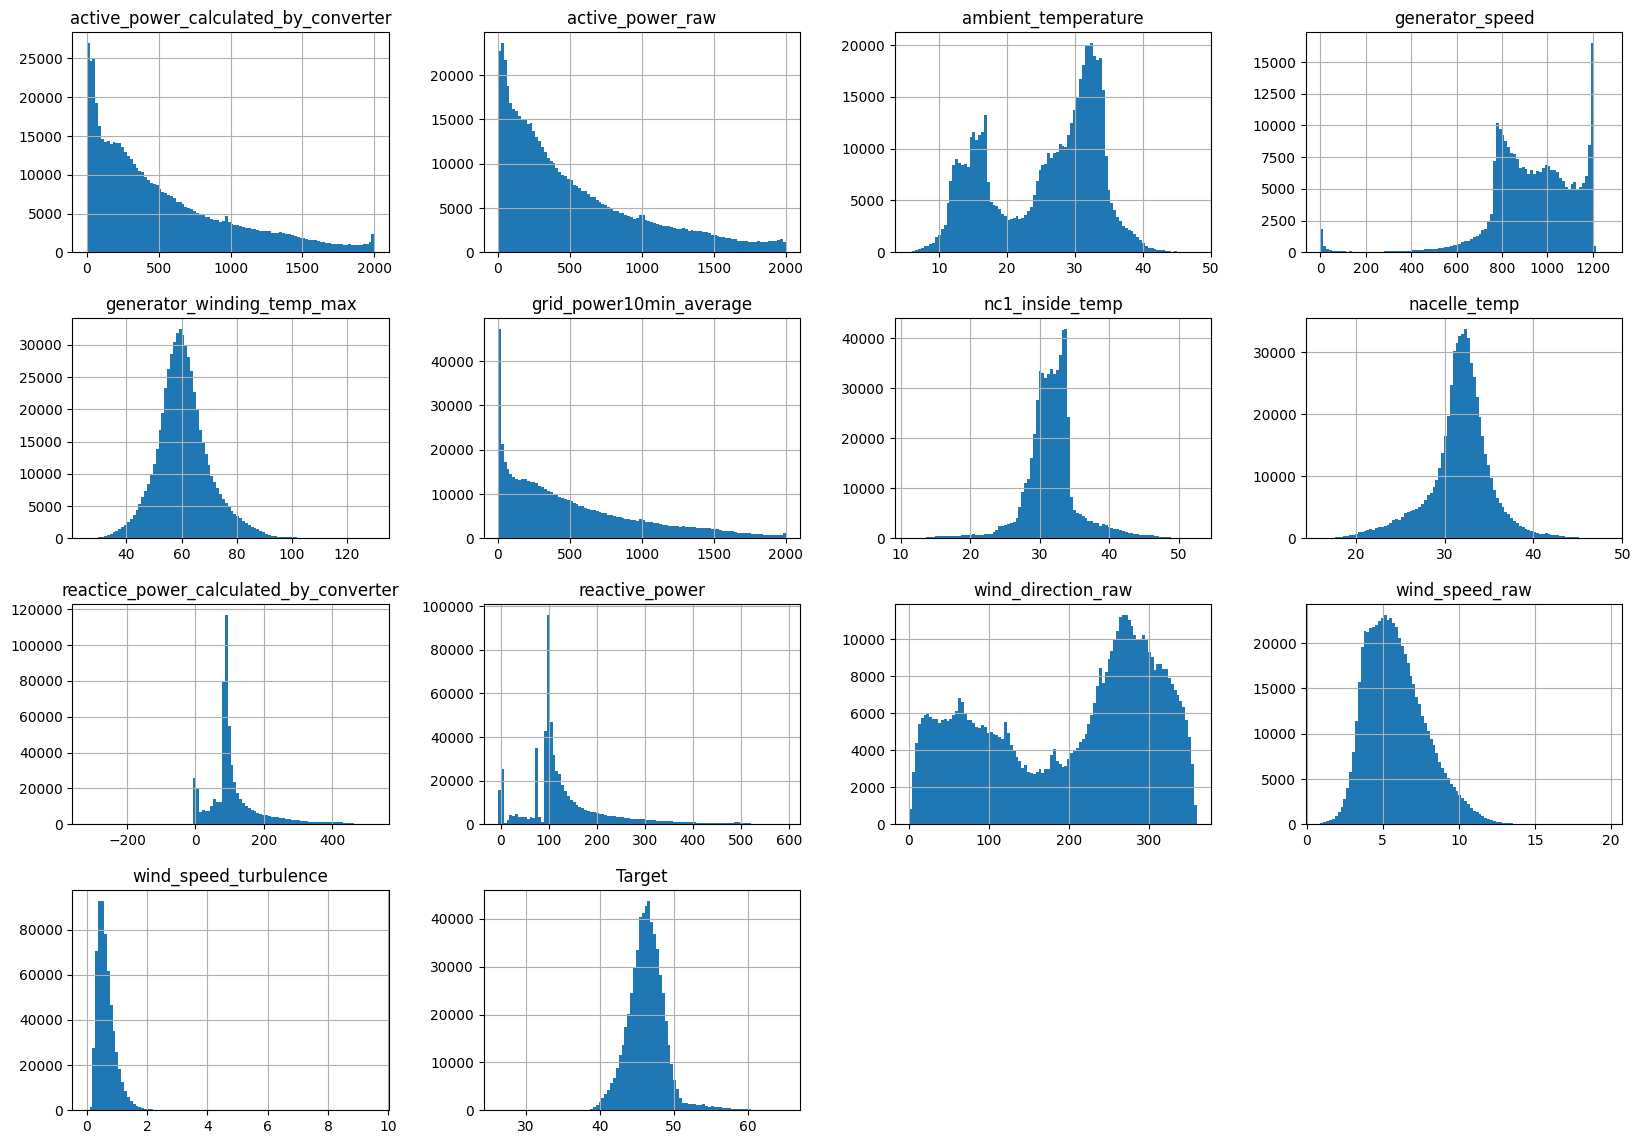

In [ ]:
# Plotting histogram to check the data distribution
import matplotlib.pyplot as plt
df.drop('id', axis=1).hist(bins=100, figsize=(20, 14))

## Split Data to Train and Test Set

In [ ]:
from sklearn.model_selection import train_test_split

df_train, df_test = train_test_split(df, test_size=0.2, random_state=42)

df_train.shape, df_test.shape

((472991, 17), (118248, 17))

## Check Linear Correlations

In [ ]:
df_train_num = df_train.drop(["turbine_id","timestamp"], axis=1)
corr = df_train_num.corr()
corr['Target'].sort_values(ascending=False)

Target                                    1.000000
nacelle_temp                              0.508863
ambient_temperature                       0.420729
generator_winding_temp_max                0.295427
nc1_inside_temp                           0.201098
wind_speed_turbulence                     0.096739
wind_direction_raw                        0.067623
id                                       -0.000512
reactice_power_calculated_by_converter   -0.034233
reactive_power                           -0.035787
active_power_raw                         -0.040669
active_power_calculated_by_converter     -0.041336
generator_speed                          -0.046246
grid_power10min_average                  -0.049477
wind_speed_raw                           -0.067833
Name: Target, dtype: float64

Features nacelle_temp, ambient_temperature, generator_winding_temp_max and nc1_inside_temp have positive correlation with the Target, which we can see in the below scatter matrix plot.

array([[<Axes: xlabel='nacelle_temp', ylabel='nacelle_temp'>,
        <Axes: xlabel='ambient_temperature', ylabel='nacelle_temp'>,
        <Axes: xlabel='generator_winding_temp_max', ylabel='nacelle_temp'>,
        <Axes: xlabel='nc1_inside_temp', ylabel='nacelle_temp'>,
        <Axes: xlabel='generator_speed', ylabel='nacelle_temp'>,
        <Axes: xlabel='Target', ylabel='nacelle_temp'>],
       [<Axes: xlabel='nacelle_temp', ylabel='ambient_temperature'>,
        <Axes: xlabel='ambient_temperature', ylabel='ambient_temperature'>,
        <Axes: xlabel='generator_winding_temp_max', ylabel='ambient_temperature'>,
        <Axes: xlabel='nc1_inside_temp', ylabel='ambient_temperature'>,
        <Axes: xlabel='generator_speed', ylabel='ambient_temperature'>,
        <Axes: xlabel='Target', ylabel='ambient_temperature'>],
       [<Axes: xlabel='nacelle_temp', ylabel='generator_winding_temp_max'>,
        <Axes: xlabel='ambient_temperature', ylabel='generator_winding_temp_max'>,
        <Ax

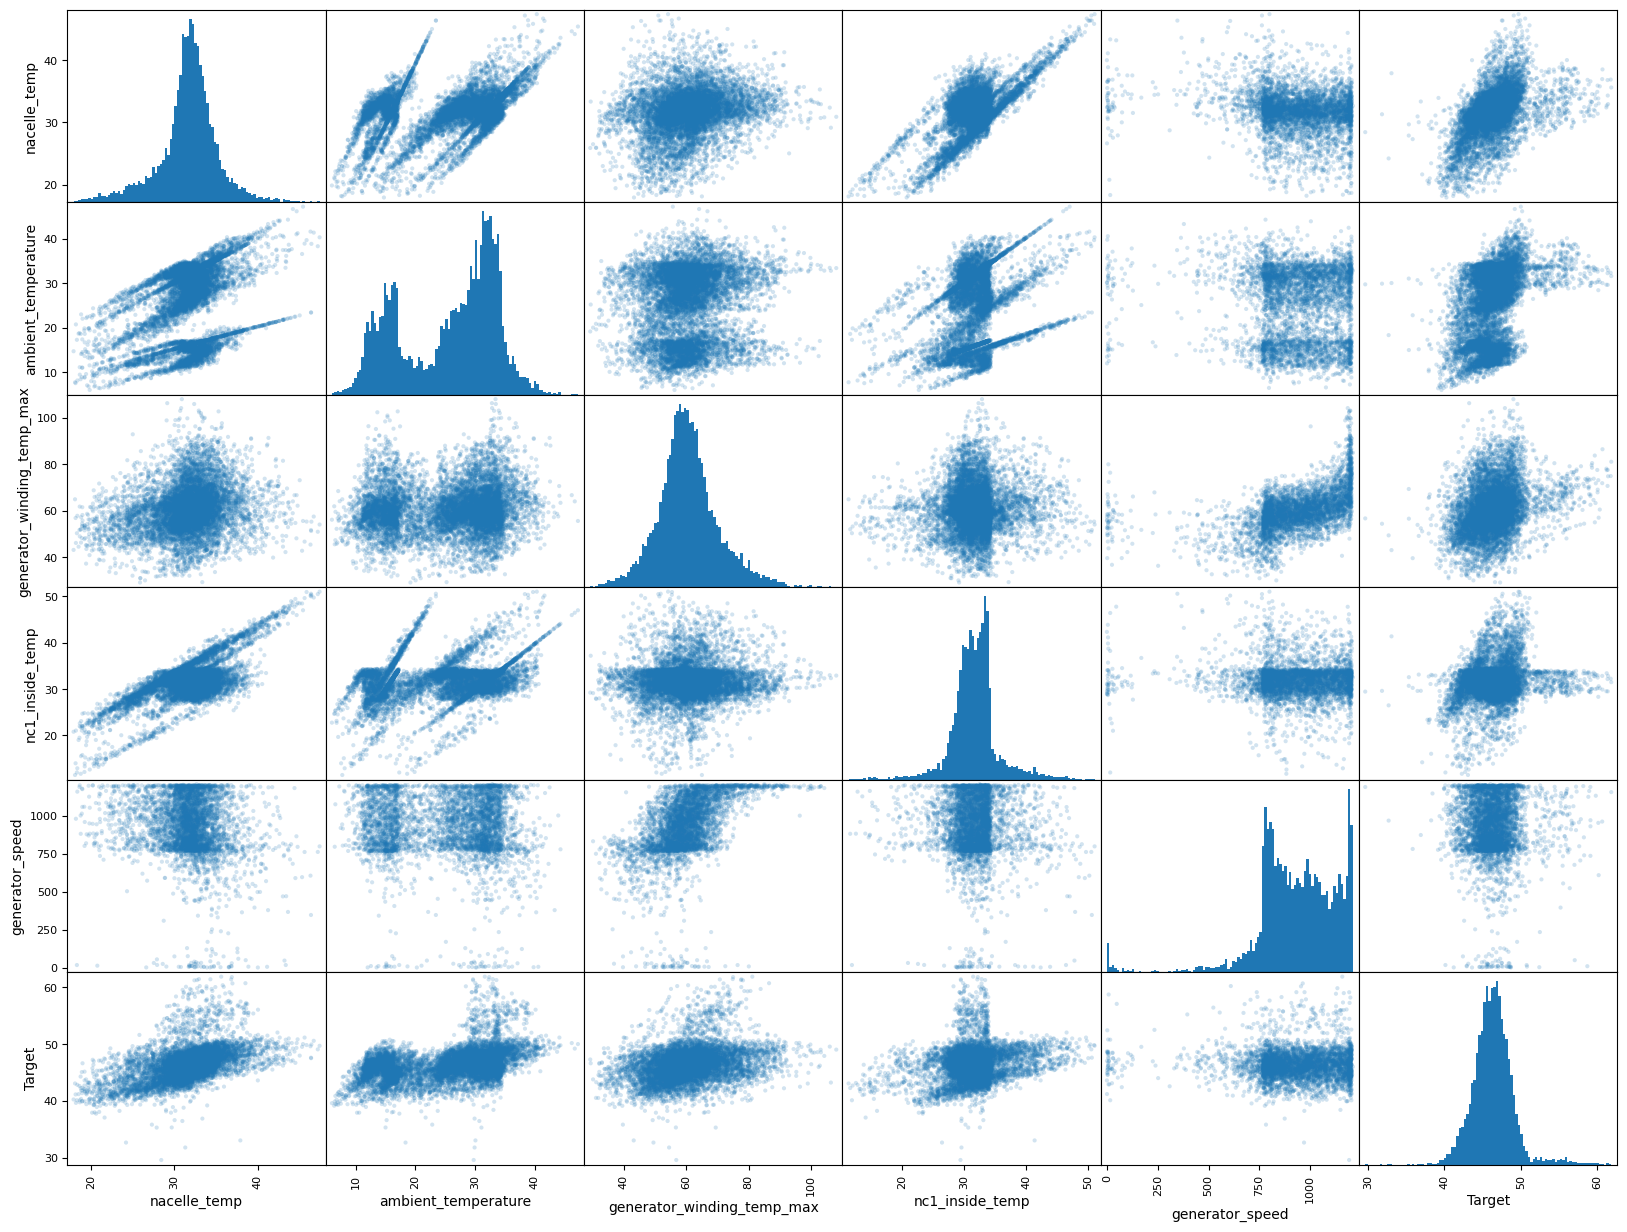

In [ ]:
from pandas.plotting import scatter_matrix

features = ["nacelle_temp", "ambient_temperature", "generator_winding_temp_max",
"nc1_inside_temp", "generator_speed", "Target"]
scatter_matrix(df_train[:10000][features], figsize=(20, 15), alpha=0.2, hist_kwds={'bins':100})

## Split Train data to features and labels

In [ ]:
df_train.info()

<class 'pandas.core.frame.DataFrame'>
Index: 472991 entries, 13236 to 121958
Data columns (total 17 columns):
 #   Column                                  Non-Null Count   Dtype  
---  ------                                  --------------   -----  
 0   id                                      472991 non-null  int64  
 1   timestamp                               472991 non-null  object 
 2   active_power_calculated_by_converter    472982 non-null  float64
 3   active_power_raw                        472977 non-null  float64
 4   ambient_temperature                     465135 non-null  float64
 5   generator_speed                         219641 non-null  float64
 6   generator_winding_temp_max              472991 non-null  float64
 7   grid_power10min_average                 472960 non-null  float64
 8   nc1_inside_temp                         472818 non-null  float64
 9   nacelle_temp                            472819 non-null  float64
 10  reactice_power_calculated_by_converter  47298

In [ ]:
df_train_labels = df_train["Target"].copy()
df_train = df_train.drop("Target", axis=1)

## Clean and Transform the Data

In [ ]:
# Taking a copy of train data for exploring preprocessing steps

df_train_copy = df_train.copy()

In [ ]:
#Lets deal with timestamp later. So taking a copy and deleting it.
# Also deleting id column

timestamp_bkp = df_train_copy['timestamp']
df_train_copy = df_train_copy.drop(['id', 'timestamp'], axis=1)

## Handle Missing values

In [ ]:
# generator_speed has lots of missing values. Its better to add a new column as a missing feature indicator.

import math
df_train_copy['generator_speed_missing'] = df_train_copy['generator_speed'].apply(lambda x: 1 if math.isnan(x) else 0)

In [ ]:
# Filling all missing numerical data with median imputation
from sklearn.impute import SimpleImputer

imputer = SimpleImputer(strategy='median')
df_train_copy_num = df_train_copy.select_dtypes(include=[np.number])
df_train_copy_num_imputed = imputer.fit_transform(df_train_copy_num)

df_train_copy_num = pd.DataFrame(df_train_copy_num_imputed, columns=df_train_copy_num.columns,
index=df_train_copy_num.index)
df_train_copy_num.info()

<class 'pandas.core.frame.DataFrame'>
Index: 472991 entries, 13236 to 121958
Data columns (total 14 columns):
 #   Column                                  Non-Null Count   Dtype  
---  ------                                  --------------   -----  
 0   active_power_calculated_by_converter    472991 non-null  float64
 1   active_power_raw                        472991 non-null  float64
 2   ambient_temperature                     472991 non-null  float64
 3   generator_speed                         472991 non-null  float64
 4   generator_winding_temp_max              472991 non-null  float64
 5   grid_power10min_average                 472991 non-null  float64
 6   nc1_inside_temp                         472991 non-null  float64
 7   nacelle_temp                            472991 non-null  float64
 8   reactice_power_calculated_by_converter  472991 non-null  float64
 9   reactive_power                          472991 non-null  float64
 10  wind_direction_raw                      47299

In [ ]:
# Filling all categorical data with most_frequent imputation
imputer = SimpleImputer(strategy='most_frequent')
df_train_copy_cat = df_train_copy.select_dtypes(include=[object])
df_train_copy_cat_imputed = imputer.fit_transform(df_train_copy_cat)

df_train_copy_cat = pd.DataFrame(df_train_copy_cat_imputed, columns=df_train_copy_cat.columns,
index=df_train_copy_cat.index)
df_train_copy_cat.info()

<class 'pandas.core.frame.DataFrame'>
Index: 472991 entries, 13236 to 121958
Data columns (total 1 columns):
 #   Column      Non-Null Count   Dtype 
---  ------      --------------   ----- 
 0   turbine_id  472991 non-null  object
dtypes: object(1)
memory usage: 7.2+ MB


In [ ]:
# Concatinating imputed dataframes
df_train_copy = pd.concat([df_train_copy_num, df_train_copy_cat], axis=1)
df_train_copy.info()

<class 'pandas.core.frame.DataFrame'>
Index: 472991 entries, 13236 to 121958
Data columns (total 15 columns):
 #   Column                                  Non-Null Count   Dtype  
---  ------                                  --------------   -----  
 0   active_power_calculated_by_converter    472991 non-null  float64
 1   active_power_raw                        472991 non-null  float64
 2   ambient_temperature                     472991 non-null  float64
 3   generator_speed                         472991 non-null  float64
 4   generator_winding_temp_max              472991 non-null  float64
 5   grid_power10min_average                 472991 non-null  float64
 6   nc1_inside_temp                         472991 non-null  float64
 7   nacelle_temp                            472991 non-null  float64
 8   reactice_power_calculated_by_converter  472991 non-null  float64
 9   reactive_power                          472991 non-null  float64
 10  wind_direction_raw                      47299

## Preprocessing - Data Transaformations

### Feature 1: **turbine_id**

In [ ]:
df_train_copy['turbine_id'].value_counts()

turbine_id
Turbine_15     30337
Turbine_18     30208
Turbine_97     30010
Turbine_120    29980
Turbine_108    29903
Turbine_105    29809
Turbine_158    29791
Turbine_14     29752
Turbine_139    29635
Turbine_13     29599
Turbine_103    29514
Turbine_123    29501
Turbine_20     29322
Turbine_19     29153
Turbine_10     28484
Turbine_01     27993
Name: count, dtype: int64

In [ ]:
#OneHot Encoding to convert categorical feature to numerical representation

from sklearn.preprocessing import OneHotEncoder

cat_encoder = OneHotEncoder(sparse_output=False)
cat_encoder_output = cat_encoder.fit_transform(df_train_copy[['turbine_id']])
cat_encoder_output_df = pd.DataFrame(cat_encoder_output, columns=cat_encoder.get_feature_names_out(), index=df_train_copy.index)
df_train_copy = pd.concat([df_train_copy, cat_encoder_output_df], axis=1)
df_train_copy = df_train_copy.drop('turbine_id', axis=1)
df_train_copy.info()

<class 'pandas.core.frame.DataFrame'>
Index: 472991 entries, 13236 to 121958
Data columns (total 30 columns):
 #   Column                                  Non-Null Count   Dtype  
---  ------                                  --------------   -----  
 0   active_power_calculated_by_converter    472991 non-null  float64
 1   active_power_raw                        472991 non-null  float64
 2   ambient_temperature                     472991 non-null  float64
 3   generator_speed                         472991 non-null  float64
 4   generator_winding_temp_max              472991 non-null  float64
 5   grid_power10min_average                 472991 non-null  float64
 6   nc1_inside_temp                         472991 non-null  float64
 7   nacelle_temp                            472991 non-null  float64
 8   reactice_power_calculated_by_converter  472991 non-null  float64
 9   reactive_power                          472991 non-null  float64
 10  wind_direction_raw                      47299

In [ ]:
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import cross_val_score
from sklearn.preprocessing import StandardScaler

def train_and_get_rmse(X, y):
    model = LinearRegression()
    model.fit(X, y)
    predictions = model.predict(X)
    return mean_squared_error(y, predictions, squared=False).round(3)

def cross_validation_rmse(X, y, k):
    model = LinearRegression()
    rmses = -cross_val_score(model, X, y,scoring="neg_root_mean_squared_error", cv=k)
    return {"mean": rmses.mean().round(3), "std": rmses.std().round(3)}

def check_score(X, y):
    print(f"RMSE on full training data: {train_and_get_rmse(df_train_copy, df_train_labels)}")
    print(f"RMSE on cross validation: {cross_validation_rmse(df_train_copy, df_train_labels, 5)}")

In [ ]:
# Training and checking the RMSE score
check_score(df_train_copy, df_train_labels)

RMSE on full training data: 1.722
RMSE on cross validation: {'mean': 1.722, 'std': 0.008}


### Feature 2: **active_power_calculated_by_converter**

<Axes: >

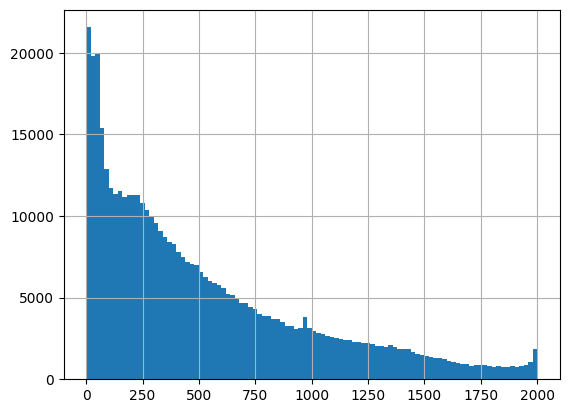

In [ ]:
df_train_copy['active_power_calculated_by_converter'].hist(bins=100)

In [ ]:
# Distribution is skewed to the right. Lets do standard scaling and natural log

def log_and_scale_transform(df, column):
    std_scaler = StandardScaler()
    log = df[[column]].apply(lambda x: np.log(x))
    return std_scaler.fit_transform(log)

df_train_copy['active_power_calculated_by_converter'] = log_and_scale_transform(df_train_copy, 'active_power_calculated_by_converter')

<Axes: >

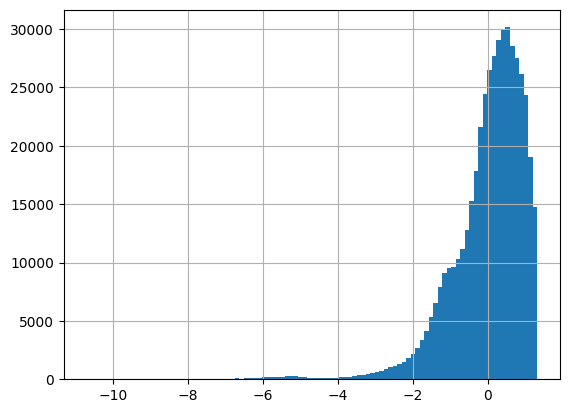

In [ ]:
df_train_copy['active_power_calculated_by_converter'].hist(bins=100)

In [ ]:
check_score(df_train_copy, df_train_labels)

RMSE on full training data: 1.722
RMSE on cross validation: {'mean': 1.722, 'std': 0.008}


### Feature 3: **active_power_raw**

<Axes: >

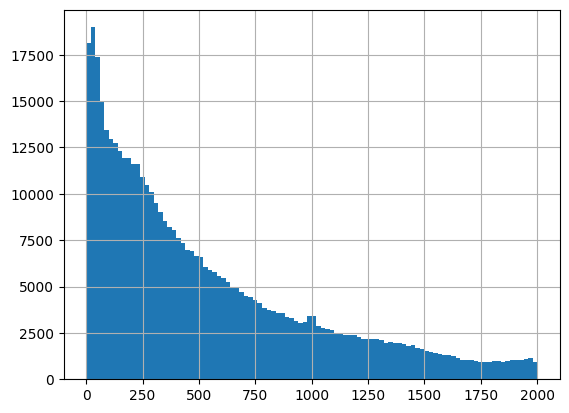

In [ ]:
df_train_copy['active_power_raw'].hist(bins=100)

<Axes: >

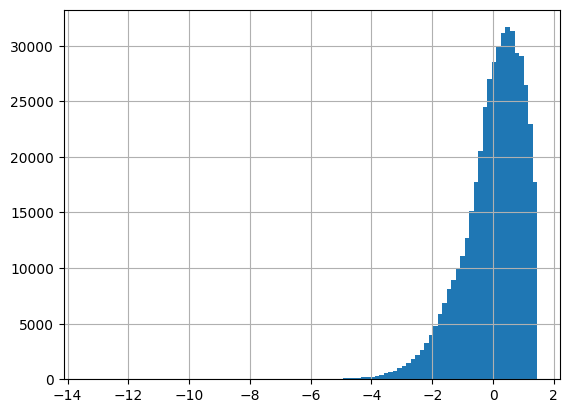

In [ ]:
df_train_copy['active_power_raw'] = log_and_scale_transform(df_train_copy, 'active_power_raw')

df_train_copy['active_power_raw'].hist(bins=100)

In [ ]:
check_score(df_train_copy, df_train_labels)

RMSE on full training data: 1.722
RMSE on cross validation: {'mean': 1.722, 'std': 0.008}


### Feature 4: **ambient_temperature**

<Axes: >

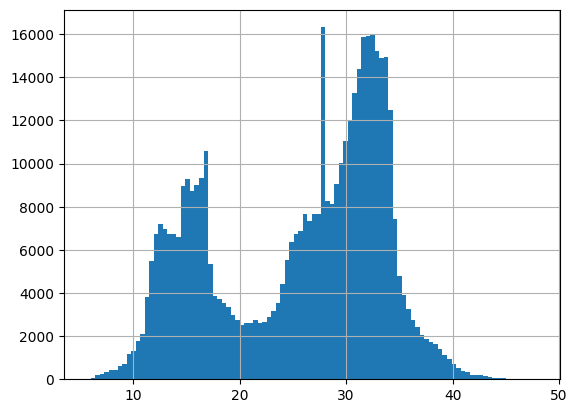

In [ ]:
df_train_copy['ambient_temperature'].hist(bins=100)

In [ ]:
# Multi modal distribution. Lets scale and create new features using Gaussian Mixture and RBF Kernel function

from sklearn.mixture import GaussianMixture
from sklearn.metrics.pairwise import rbf_kernel
from sklearn.preprocessing import FunctionTransformer

def scale_transform(x):
    std_scaler = StandardScaler()
    return std_scaler.fit_transform(x)

df_train_copy['ambient_temperature'] = scale_transform(df_train_copy[['ambient_temperature']])

In [ ]:
def guassian_rbf_similarities(df, column, components):
    gmm = GaussianMixture(n_components=components)
    gmm.fit(df[[column]])
    gmm_means = np.squeeze(gmm.means_)

    gmm_transformer = FunctionTransformer(rbf_kernel, kw_args=dict(Y=gmm.means_.tolist(), gamma=0.1))
    gmm_simil = gmm_transformer.transform(df[[column]])
    gmm_simil_df = pd.DataFrame(gmm_simil, columns=[column +'_simil_'+ str(i) for i in range(components)],
                            index=df.index)
    return gmm_simil_df

In [ ]:
gmm_simil_df = guassian_rbf_similarities(df_train_copy, 'ambient_temperature', 3)
df_train_copy = pd.concat([df_train_copy, gmm_simil_df], axis=1)

In [ ]:
df_train_copy.info()

<class 'pandas.core.frame.DataFrame'>
Index: 472991 entries, 13236 to 121958
Data columns (total 33 columns):
 #   Column                                  Non-Null Count   Dtype  
---  ------                                  --------------   -----  
 0   active_power_calculated_by_converter    472991 non-null  float64
 1   active_power_raw                        472991 non-null  float64
 2   ambient_temperature                     472991 non-null  float64
 3   generator_speed                         472991 non-null  float64
 4   generator_winding_temp_max              472991 non-null  float64
 5   grid_power10min_average                 472991 non-null  float64
 6   nc1_inside_temp                         472991 non-null  float64
 7   nacelle_temp                            472991 non-null  float64
 8   reactice_power_calculated_by_converter  472991 non-null  float64
 9   reactive_power                          472991 non-null  float64
 10  wind_direction_raw                      47299

In [ ]:
check_score(df_train_copy, df_train_labels)

RMSE on full training data: 1.716
RMSE on cross validation: {'mean': 1.716, 'std': 0.008}


There is a slight improvement in score !

### Feature 5: **generator_speed**

<Axes: >

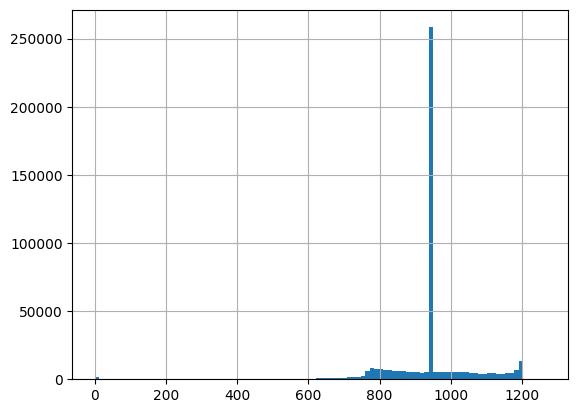

In [ ]:
df_train_copy['generator_speed'].hist(bins=100)

The peak around the middle is due to the median imputation on missing data. It should not create a problem since we added a missing indicator feature for generator_speed.

In [ ]:
df_train_copy['generator_speed'] = scale_transform(df_train_copy[['generator_speed']])

In [ ]:
check_score(df_train_copy, df_train_labels)

RMSE on full training data: 1.716
RMSE on cross validation: {'mean': 1.716, 'std': 0.008}


### Feature 6: **generator_winding_temp_max**

<Axes: >

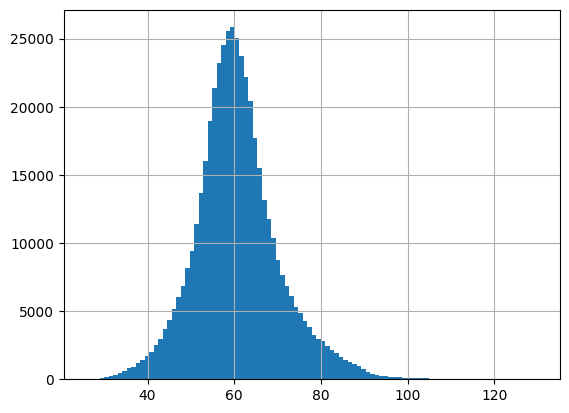

In [ ]:
df_train_copy['generator_winding_temp_max'].hist(bins=100)

In [ ]:
#Already in normal distribution. So lets do only scaling.

df_train_copy['generator_winding_temp_max'] = scale_transform(df_train_copy[['generator_winding_temp_max']])

In [ ]:
check_score(df_train_copy, df_train_labels)

RMSE on full training data: 1.716
RMSE on cross validation: {'mean': 1.716, 'std': 0.008}


### Feature 7: **grid_power10min_average**

<Axes: >

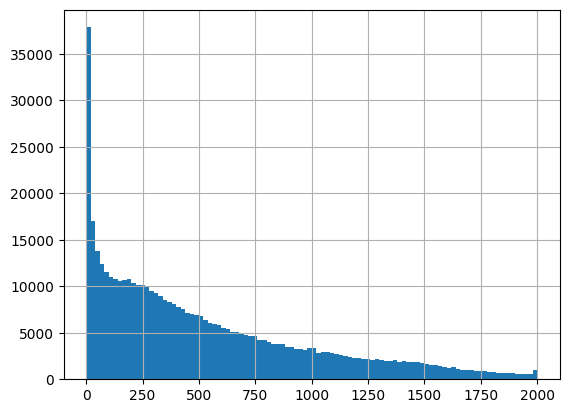

In [ ]:
df_train_copy['grid_power10min_average'].hist(bins=100)

<Axes: >

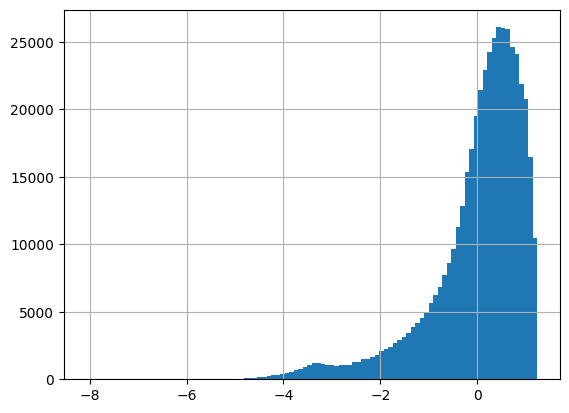

In [ ]:
# Distribution is skewed to the right.

df_train_copy['grid_power10min_average'] = log_and_scale_transform(df_train_copy, 'grid_power10min_average')
df_train_copy['grid_power10min_average'].hist(bins=100)

In [ ]:
check_score(df_train_copy, df_train_labels)

RMSE on full training data: 1.73
RMSE on cross validation: {'mean': 1.731, 'std': 0.008}


### Feature 7: **nc1_inside_temp**

<Axes: >

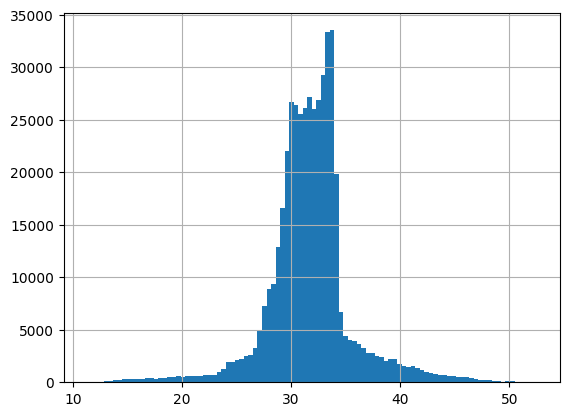

In [ ]:
df_train_copy['nc1_inside_temp'].hist(bins=100)

In [ ]:
df_train_copy['nc1_inside_temp'] = scale_transform(df_train_copy[['nc1_inside_temp']])

In [ ]:
check_score(df_train_copy, df_train_labels)

RMSE on full training data: 1.73
RMSE on cross validation: {'mean': 1.731, 'std': 0.008}


### Feature 8: **nacelle_temp**

<Axes: >

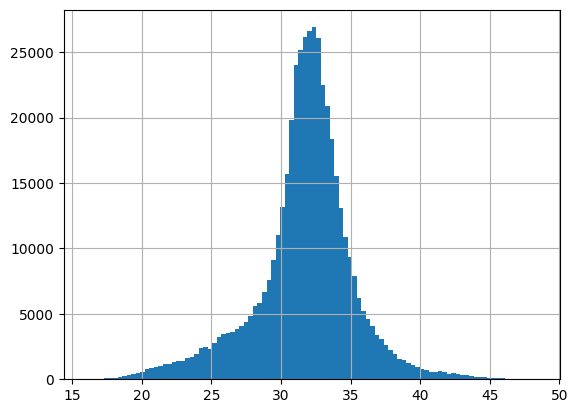

In [ ]:
df_train_copy['nacelle_temp'].hist(bins=100)

In [ ]:
df_train_copy['nacelle_temp'] = scale_transform(df_train_copy[['nacelle_temp']])
check_score(df_train_copy, df_train_labels)

RMSE on full training data: 1.73
RMSE on cross validation: {'mean': 1.731, 'std': 0.008}


### Feature 9: **reactice_power_calculated_by_converter**

<Axes: >

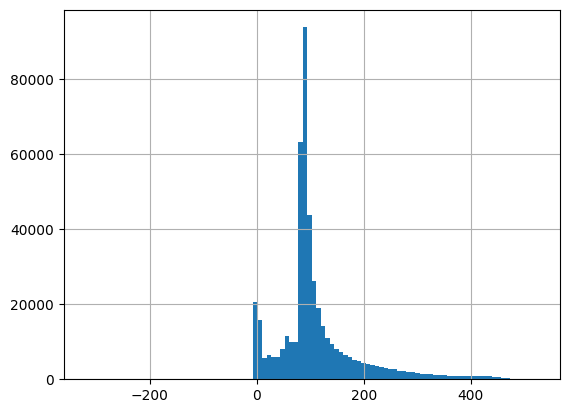

In [ ]:
df_train_copy['reactice_power_calculated_by_converter'].hist(bins=100)

In [ ]:
df_train_copy['reactice_power_calculated_by_converter'] = scale_transform(df_train_copy[['reactice_power_calculated_by_converter']])
check_score(df_train_copy, df_train_labels)

RMSE on full training data: 1.73
RMSE on cross validation: {'mean': 1.731, 'std': 0.008}


In [ ]:
# Lets try the guassian mixture and rbf kernel to find the modes and similarity features here as well

gmm_simil_df = guassian_rbf_similarities(df_train_copy, 'reactice_power_calculated_by_converter', 2)
df_train_copy = pd.concat([df_train_copy, gmm_simil_df], axis=1)

In [ ]:
check_score(df_train_copy, df_train_labels)

RMSE on full training data: 1.716
RMSE on cross validation: {'mean': 1.716, 'std': 0.008}


### Feature 10: **reactive_power**

<Axes: >

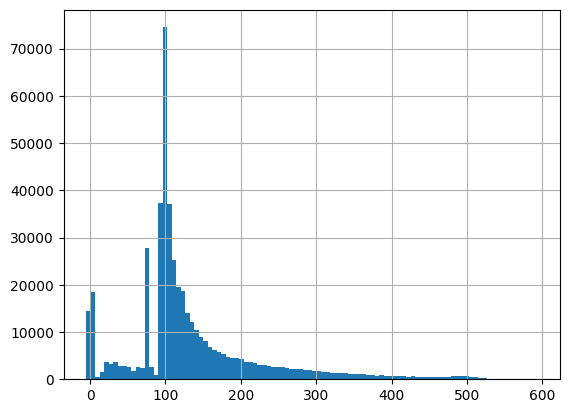

In [ ]:
df_train_copy['reactive_power'].hist(bins=100)

In [ ]:
df_train_copy['reactive_power'] = scale_transform(df_train_copy[['reactive_power']])

In [ ]:
# Looks like a multi modal distribution

gmm_simil_df = guassian_rbf_similarities(df_train_copy, 'reactive_power', 3)
df_train_copy = pd.concat([df_train_copy, gmm_simil_df], axis=1)

In [ ]:
check_score(df_train_copy, df_train_labels)

RMSE on full training data: 1.713
RMSE on cross validation: {'mean': 1.713, 'std': 0.008}


### Feature 11: **wind_direction_raw**

<Axes: >

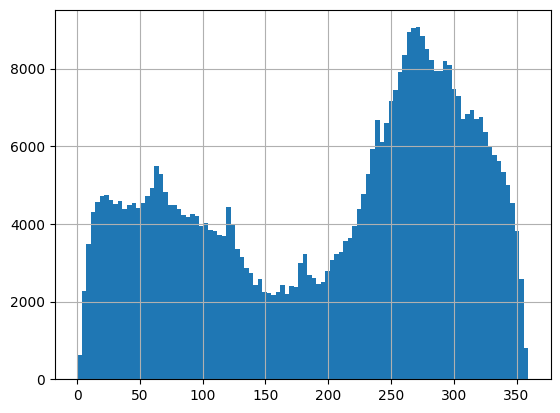

In [ ]:
df_train_copy['wind_direction_raw'].hist(bins=100)

In [ ]:
df_train_copy['wind_direction_raw'] = scale_transform(df_train_copy[['wind_direction_raw']])

In [ ]:
#Multi modal distribution

gmm_simil_df = guassian_rbf_similarities(df_train_copy, 'wind_direction_raw', 2)
df_train_copy = pd.concat([df_train_copy, gmm_simil_df], axis=1)

In [ ]:
df_train_copy.info()

<class 'pandas.core.frame.DataFrame'>
Index: 472991 entries, 13236 to 121958
Data columns (total 40 columns):
 #   Column                                          Non-Null Count   Dtype  
---  ------                                          --------------   -----  
 0   active_power_calculated_by_converter            472991 non-null  float64
 1   active_power_raw                                472991 non-null  float64
 2   ambient_temperature                             472991 non-null  float64
 3   generator_speed                                 472991 non-null  float64
 4   generator_winding_temp_max                      472991 non-null  float64
 5   grid_power10min_average                         472991 non-null  float64
 6   nc1_inside_temp                                 472991 non-null  float64
 7   nacelle_temp                                    472991 non-null  float64
 8   reactice_power_calculated_by_converter          472991 non-null  float64
 9   reactive_power             

In [ ]:
check_score(df_train_copy, df_train_labels)

RMSE on full training data: 1.712
RMSE on cross validation: {'mean': 1.713, 'std': 0.008}


### Feature 12: **wind_speed_raw**

<Axes: >

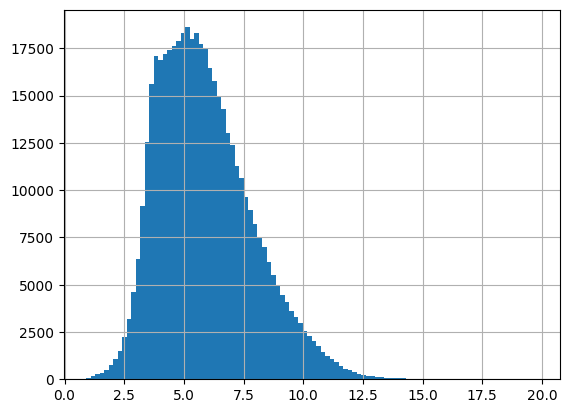

In [ ]:
df_train_copy['wind_speed_raw'].hist(bins=100)

In [ ]:
df_train_copy['wind_speed_turbulence'] = scale_transform(df_train_copy[['wind_speed_turbulence']])
check_score(df_train_copy, df_train_labels)

RMSE on full training data: 1.712
RMSE on cross validation: {'mean': 1.713, 'std': 0.008}


### Feature 13: **wind_speed_turbulence**

<Axes: >

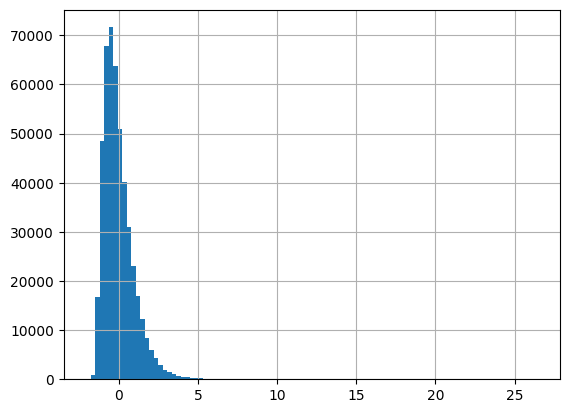

In [ ]:
df_train_copy['wind_speed_turbulence'].hist(bins=100)

In [ ]:
df_train_copy['wind_speed_turbulence'] = scale_transform(df_train_copy[['wind_speed_turbulence']])
check_score(df_train_copy, df_train_labels)

RMSE on full training data: 1.712
RMSE on cross validation: {'mean': 1.713, 'std': 0.008}


### Feature 14: **timestamp**

In [ ]:
# Lets create new features hour and month from timestamp. Assuming time of day and month can have an impact on temerature.

datetime = pd.DatetimeIndex(timestamp_bkp)
df_train_copy['hour'] = datetime.hour
df_train_copy['month'] = datetime.month

In [ ]:
#One Hot Encoding for hour

cat_encoder = OneHotEncoder(sparse_output=False)
cat_encoder_output = cat_encoder.fit_transform(df_train_copy[['hour']])
cat_encoder_output_df = pd.DataFrame(cat_encoder_output, columns=cat_encoder.get_feature_names_out(), index=df_train_copy.index)
df_train_copy = pd.concat([df_train_copy, cat_encoder_output_df], axis=1)
df_train_copy = df_train_copy.drop('hour', axis=1)

In [ ]:
#One Hot Encoding for hour

cat_encoder = OneHotEncoder(sparse_output=False)
cat_encoder_output = cat_encoder.fit_transform(df_train_copy[['month']])
cat_encoder_output_df = pd.DataFrame(cat_encoder_output, columns=cat_encoder.get_feature_names_out(), index=df_train_copy.index)
df_train_copy = pd.concat([df_train_copy, cat_encoder_output_df], axis=1)
df_train_copy = df_train_copy.drop('month', axis=1)

In [ ]:
check_score(df_train_copy, df_train_labels)

RMSE on full training data: 1.617
RMSE on cross validation: {'mean': 1.617, 'std': 0.008}


Yes, it really did improve the score!

## Comparing some random predictions with actual values

In [ ]:
model = LinearRegression()
model.fit(df_train_copy, df_train_labels)

np.random.seed(42)
shuffled_indices = np.random.permutation(len(df_train_copy))
few_random_indices = shuffled_indices[:100]
predictions = model.predict(df_train_copy.iloc[few_random_indices])
compare_df = pd.DataFrame({"actual": df_train_labels.iloc[few_random_indices], "predictions": predictions}).round(2)
compare_df.head()

,actual,predictions
209368,54.84,51.21
530013,47.82,45.57
529889,48.96,50.74
539115,49.01,46.32
558149,47.33,45.18


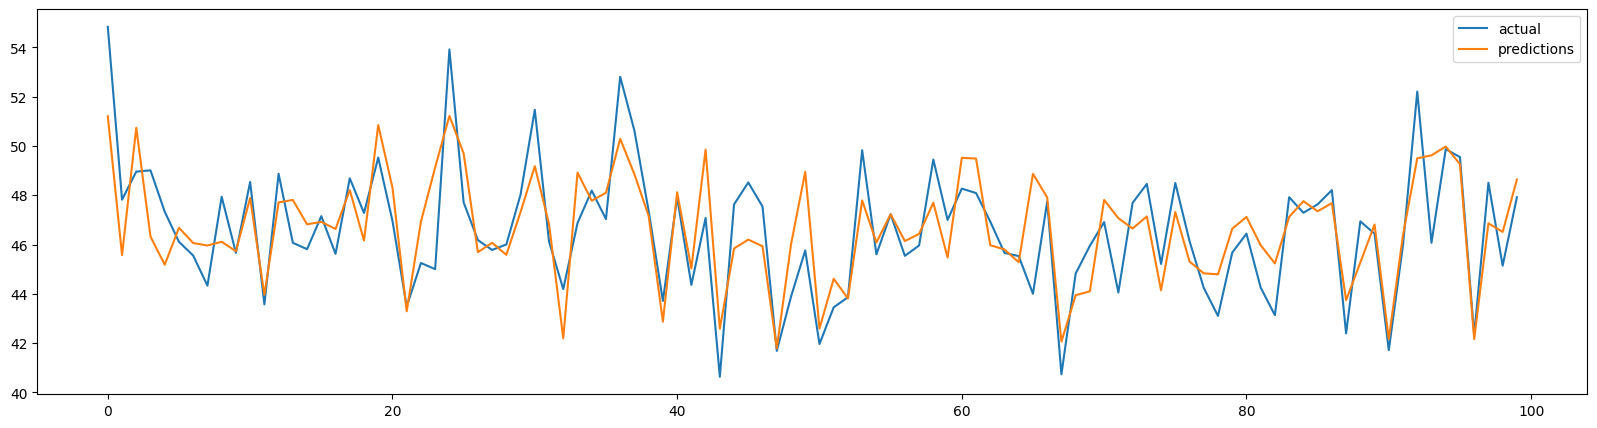

In [ ]:
plt.figure(figsize=(20,5))
plt.plot(np.arange(0,100), compare_df['actual'], label="actual")
plt.plot(np.arange(0,100), compare_df['predictions'], label="predictions")
plt.legend(loc="upper right")

## Summary of Preprocessing steps for all features in dataset.

**Missing Indicator Feature**
- generator_speed

**Median Imputaion & Standard Scaling**
- generator_winding_temp_max
- nc1_inside_temp
- nacelle_temp
- wind_speed_raw
- wind_speed_turbulence
- generator_speed
- ambient_temperature
- reactive_power
- reactice_power_calculated_by_converter
- wind_direction_raw

**Median Imputaion, Natural Log & Standard Scaling**
- active_power_calculated_by_converter
- active_power_raw
- grid_power10min_average

**3 New Guassian RBF Features**
- ambient_temperature
- reactive_power

**2 New Guassian RBF Features**
- reactice_power_calculated_by_converter
- wind_direction_raw

**Most Frequent Imputaion & One Hot Encoding**
- turbine_id

**Deletion**
- id
- timestamp (after extracting new features *hour* and *month* (both one hot encoded)

## Create scikit-learn pipeline

Creating a pipeline is important for automating the training and inference steps! So lets automate the steps we have done for preprocessing and training the model.

In [ ]:
import math
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import StandardScaler, OneHotEncoder, FunctionTransformer
from sklearn.pipeline import make_pipeline
from sklearn.compose import ColumnTransformer, make_column_selector
from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.mixture import GaussianMixture
from sklearn.metrics.pairwise import rbf_kernel
from sklearn.preprocessing import FunctionTransformer

#Median Imputaion & Standard Scaling
standard_num_pipeline = make_pipeline(
    SimpleImputer(strategy="median"),
    StandardScaler()
)

#New Missing Indicator Feature
def add_missing_indicator(X):
    return X.iloc[:,0].apply(lambda x: 1 if math.isnan(x) else 0).to_frame()

def missing_indicator_name(function_transformer, feature_names_in):
    return ["missing"] # feature names out

missing_indicator_pipeline = make_pipeline(
        FunctionTransformer(add_missing_indicator, feature_names_out=missing_indicator_name)
)

#Median Imputaion, Natural Log & Standard Scaling
log_pipeline = make_pipeline(
    SimpleImputer(strategy="median"),
    FunctionTransformer(np.log, feature_names_out="one-to-one"),
    StandardScaler()
)

#New Guassian RBF Features
class GuassianRBFSimilarity(BaseEstimator, TransformerMixin):
    def __init__(self, n_components=3, gamma=0.1, random_state=None, feature_name=None):
        self.n_components = n_components
        self.gamma = gamma
        self.random_state = random_state
        self.feature_name = feature_name

    def fit(self, X, y=None):
        self.gmm_ = GaussianMixture(n_components=self.n_components, random_state=self.random_state)
        self.gmm_.fit(X)
        return self

    def transform(self, X):
        return rbf_kernel(X, self.gmm_.means_, gamma=self.gamma)

    def get_feature_names_out(self, names=None):
        return [f"self.feature_name_{i}_similarity" for i in range(self.n_components)]


def guassian_rbf_pipeline(components, feature_name):
    return make_pipeline(
        SimpleImputer(strategy="median"),
        StandardScaler(),
        GuassianRBFSimilarity(n_components=components, gamma=0.1, random_state=42, feature_name=feature_name)
    )

#Most-Frequent Imputaion & One Hot Encoding
category_pipeline = make_pipeline(
    SimpleImputer(strategy="most_frequent"),
    OneHotEncoder(handle_unknown="ignore")
)

#Extract hour from timestamp with Most-Frequent Imputation and OneHot Encoding
def extract_hour_from_timestamp(X):
    return pd.DatetimeIndex(X[:,0]).hour.to_frame()

def hour_feature_name_out(function_transformer, feature_names_in):
    print(feature_names_in)
    return ["hour"] # feature names out

date_to_hour_pipeline = make_pipeline(
    SimpleImputer(strategy="most_frequent"),
    FunctionTransformer(extract_hour_from_timestamp, feature_names_out=hour_feature_name_out),
    OneHotEncoder(handle_unknown="ignore")
)

#Extract month from timestamp with Most-Frequent Imputation and OneHot Encoding
def extract_month_from_timestamp(X):
    return pd.DatetimeIndex(X[:,0]).month.to_frame()

def month_feature_name_out(function_transformer, feature_names_in):
    print(feature_names_in)
    return ["month"] # feature names out

date_to_month_pipeline = make_pipeline(
    SimpleImputer(strategy="most_frequent"),
    FunctionTransformer(extract_month_from_timestamp, feature_names_out=month_feature_name_out),
    OneHotEncoder(handle_unknown="ignore")
)

#Preprocessing pipeline
preprocessing = ColumnTransformer([
    ("date_to_month", date_to_month_pipeline, ["timestamp"]),
    ("date_to_hour", date_to_hour_pipeline, ["timestamp"]),
    ("missing_indicator", missing_indicator_pipeline, ["generator_speed"]),
    ("natural_log", log_pipeline, ["active_power_calculated_by_converter",
                                   "active_power_raw",
                                   "grid_power10min_average"
                                  ]),

    ('guassian_0', guassian_rbf_pipeline(3, "ambient_temperature"), ["ambient_temperature"]),
    ('guassian_1', guassian_rbf_pipeline(3, "reactive_power"), ["reactive_power"]),
    ('guassian_2', guassian_rbf_pipeline(2, "reactice_power_calculated_by_converter"), ["reactice_power_calculated_by_converter"]),
    ('guassian_3', guassian_rbf_pipeline(2, "wind_direction_raw"), ["wind_direction_raw"]),
    ("category", category_pipeline, ["turbine_id"]),
    ('standard', standard_num_pipeline, ["generator_speed",
                                        "generator_winding_temp_max",
                                        "nc1_inside_temp",
                                        "nacelle_temp",
                                        "wind_speed_raw",
                                        "wind_speed_turbulence",
                                        "ambient_temperature",
                                        "reactive_power",
                                        "reactice_power_calculated_by_converter",
                                        "wind_direction_raw"
                                       ])
])

In [ ]:
print(f"shape after preprocessing pipeline on df_train: {preprocessing.fit_transform(df_train).shape}")
print(f"shape of df_train_copy: {df_train_copy.shape}")

shape after preprocessing pipeline on df_train: (472991, 76)
shape of df_train_copy: (472991, 76)


Preprocessing pipeline did the same transformations on df_train which we have done manually on df_train_copy.

In [ ]:
import sklearn
sklearn.set_config(display="diagram")

preprocessing

ColumnTransformer(transformers=[('date_to_month',
                                 Pipeline(steps=[('simpleimputer',
                                                  SimpleImputer(strategy='most_frequent')),
                                                 ('functiontransformer',
                                                  FunctionTransformer(feature_names_out=<function month_feature_name_out at 0x7b1eb57c9b40>,
                                                                      func=<function extract_month_from_timestamp at 0x7b1eb57c9ab0>)),
                                                 ('onehotencoder',
                                                  OneHotEncoder(handle_unknown='ignore')...
                                 ['turbine_id']),
                                ('standard',
                                 Pipeline(steps=[('simpleimputer',
                                                  SimpleImputer(strategy='median')),
                                                 ('standardscaler',
                                                  StandardScaler())]),
                                 ['generator_speed',
                                  'generator_winding_temp_max',
                                  'nc1_inside_temp', 'nacelle_temp',
                                  'wind_speed_raw', 'wind_speed_turbulence',
                                  'ambient_temperature', 'reactive_power',
                                  'reactice_power_calculated_by_converter',
                                  'wind_direction_raw'])])

In [ ]:
# Training Linear Regression model after the preprocessing pipeline.

from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error

model_pipeline = make_pipeline(preprocessing, LinearRegression())
model_pipeline.fit(df_train, df_train_labels)

predictions = model_pipeline.predict(df_train)
train_rmse = mean_squared_error(df_train_labels, predictions, squared=False)

print(f"Train RMSE: {train_rmse.round(3)}")

Train RMSE: 1.617


In [ ]:
# Testing the model on test data

df_test_labels = df_test["Target"].copy()
df_test = df_test.drop("Target", axis=1)

predictions = model_pipeline.predict(df_test) #df_test will also go throgh the same preprocessing pipeline
test_rmse = mean_squared_error(df_test_labels, predictions, squared=False)

print(f"Test RMSE: {test_rmse.round(3)}")

Test RMSE: 1.612


We were able to create a decent model without any overfitting.

## Submission

In [ ]:
ids = df_unknown['id']

predictions = model_pipeline.predict(df_unknown)
output_df = pd.DataFrame({'id': ids,
                       'Target': predictions.squeeze()})

output_df.to_csv('content/kaggle/working/submission.csv', index=False)
output_df.head()

,id,Target
0,0,44.867126
1,1,42.665222
2,2,45.697327
3,3,48.036194
4,4,45.861023
